# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [62]:
# student 1: Tomer 5323
# student 2: Amiram 1317
# student 3: Roni 0502


## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
AI agent name: ChatGPT (OpenAI o4-mini)
Goal:Refine and debug Part 3 (Experiments) of the Titanic ML workflow: ensure all feature-engineering is inside cross-validation, fix imports, and streamline the GridSearchCV setup.

Prompt 1:
How can I build a scikit-learn Pipeline so that imputation, scaling and one-hot encoding are fit only on each train_fold and then applied on the corresponding validation_fold within cross_val_score, to avoid any data leakage?

Prompt 2:
I’m getting NameError: name 'OneHotEncoder' is not defined. Which exact import statement am I missing, and where should I place it at the top of my notebook?


Prompt 3:
Instead of manually looping over my 'use_family' and 'use_age' flags, how can I include these boolean feature-engineering options directly in GridSearchCV’s param_grid (using a FunctionTransformer) so that it automatically tests all combinations alongside the model hyperparameters?


Other assistanse:    
• Consulted the official scikit-learn docs for Pipeline, ColumnTransformer, FunctionTransformer and GridSearchCV.

<pre></pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:


We’re trying to predict whether a Titanic passenger survived (the Survived column).
The training set contains 712 samples with features like Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, etc., plus the Survived label.
The test set contains 179 samples with the same features (Survived hidden).
Our goal is to run combined experiments of feature engineering (e.g., creating FamilySize and AgeCategory), algorithms (e.g., KNN, Decision Tree) and hyperparameter tuning using 5-Fold Cross-Validation and Grid Search, to identify the combination that maximizes f1_macro while preventing data leakage between training and validation.

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>




    
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

In [70]:
# טעינת ספריות וקריאת קובץ ה-Train
import pandas as pd
import matplotlib.pyplot as plt

trainset = pd.read_csv("titanic_train.csv")
trainset.head()   # הצגה של חמש השורות הראשונות 


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [71]:
#קריאת קובץ ה-test set 
testset = pd.read_csv("titanic_test.csv")
testset.head()    # חמש השורות הראשונות מתוך ה-testset


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


In [72]:
# הצגת סיכום סטטיסטי (ספירה, ממוצע, סטיית תקן, רבעונים וכו') על ה-trainset
trainset.describe()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.294944,0.640449,29.531213,0.528090,0.384831,32.379429,0.372191,0.394663
std,0.841990,0.480206,13.188028,1.055052,0.803085,49.836074,0.649970,0.489122
min,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.750000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000,0.000000
50%,3.000000,1.000000,29.699118,0.000000,0.000000,14.500000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,1.000000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000,1.000000


In [73]:
# הצגה טבלאית 2
# הצגת העמודות, טיפוס הנתונים בכל עמודה, וכמה ערכים חסרים בעמודה
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int64  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    int64  
 7   Survived  712 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 44.6 KB


In [74]:
# הצגה טבלאית 3
# חישוסב מטריצת המקדמים, שזו מטריצה המודדת את הקשר הלינארי בין שני משתנים
#הערכים נעים בין 1 ל1- כך ש: 1 מצביע על קשר חיובי מושלם, 1- על קשר שלילי מושלם ו-0 על חוסר קשר

corr_matrix = trainset.corr()
corr_matrix

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
Pclass,1.000000,0.126986,-0.319927,0.093572,0.048225,-0.543722,0.040708,-0.324024
Sex,0.126986,1.000000,0.089108,-0.079976,-0.242467,-0.183650,-0.124908,-0.550699
Age,-0.319927,0.089108,1.000000,-0.270404,-0.202725,0.071787,0.031524,-0.072729
SibSp,0.093572,-0.079976,-0.270404,1.000000,0.415491,0.136861,-0.049109,-0.031052
Parch,0.048225,-0.242467,-0.202725,0.415491,1.000000,0.151631,-0.072698,0.074699
Fare,-0.543722,-0.183650,0.071787,0.136861,0.151631,1.000000,0.078197,0.264345
Embarked,0.040708,-0.124908,0.031524,-0.049109,-0.072698,0.078197,1.000000,0.099162
Survived,-0.324024,-0.550699,-0.072729,-0.031052,0.074699,0.264345,0.099162,1.000000


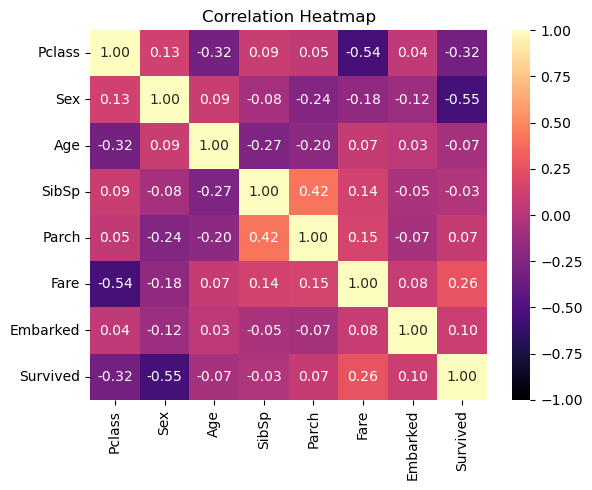

In [75]:
# הצגה ויזואלית 1 
#יצירת מפת חום למטריצת המתאם
#ניתן לראות כאן שעבור הצבע צהוב בהיר- התקשר מושלם כי זה משתנה מול עצמו
#גוונים אדום כתום מראים על קשר חיובי
#גוונים כחולים כהים-שחורים מראים על קשר שלילי
#גוון סגול-ורוד מצביע על חוסר קשר

plt.figure()
sns.heatmap(corr_matrix, annot=True, fmt='.2f',cmap='magma', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


Text(0.5, 1.0, 'Continuous Variables - before scaling...')

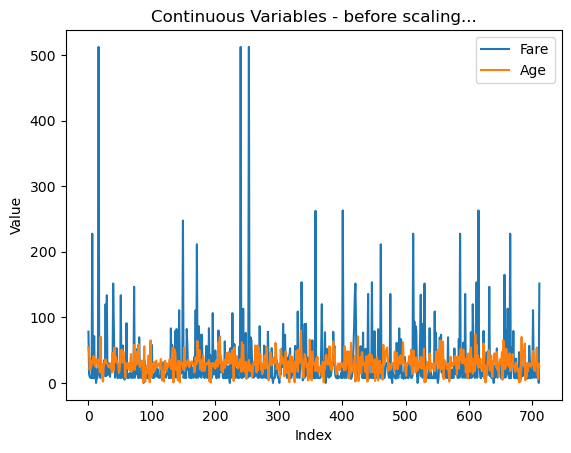

In [76]:
# הצגה ויזואלית 2 
# הנתונים בעלי ערך רציף ובטווחים קיצוניים בין עמודות
#ניתן לראות שהגרף קשה לקריאה וניתוח הנתונים כך עלול לפגוע בתוצאות הניסויים
#בהמשך נראה את הגרף שוב, לאחר ביצוע סקאלינג

continuous_columns = ['Fare','Age']
trainset[continuous_columns].plot()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Continuous Variables - before scaling...')

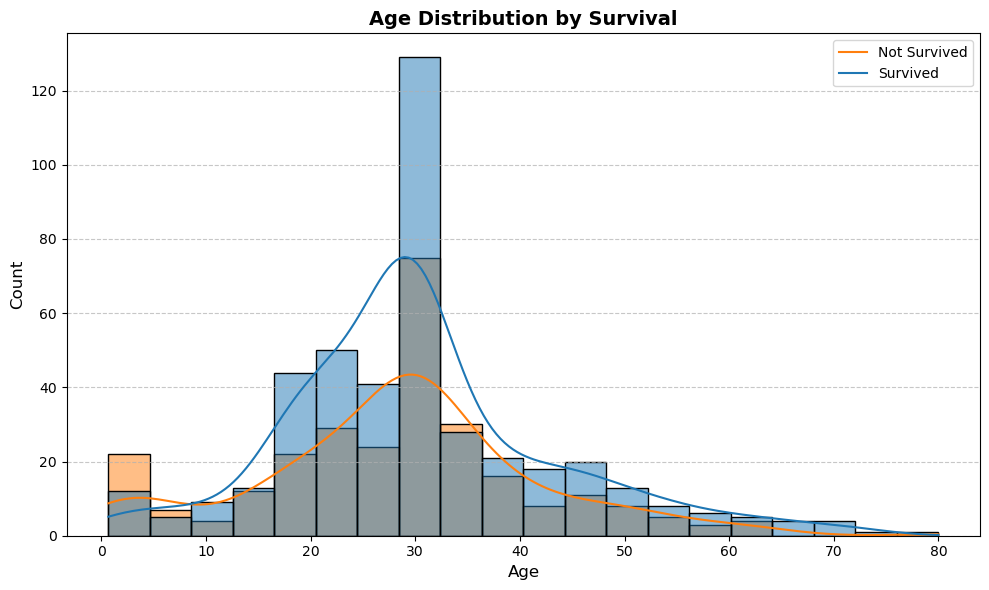

In [77]:
# הצגה ויזואלית 3 
#יצירת גרף התפלגות גיל הנוסעים לפי הישרדותם
#ניתו לראות שרוב הנוסעים שלא שרדו היא בקבוצת הגילאים 20-30 והנוסעים ששרדו היו בעיקר בני 20-40
plt.figure(figsize=(10, 6))
sns.histplot(data=trainset, x='Age', hue='Survived', kde=True, bins=20)
plt.title('Age Distribution by Survival', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(['Not Survived', 'Survived'])
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Part 3 - Experiments
You could add as many code cells as needed

In [79]:
#בדיקת ערכים חסרים
# ניתן לראות שאין ערכים חסרים גם בטריין-סט וגם בטסט-סט, ולכן אין צורך בטיפול בהם

missing_train = trainset.isnull().sum()
missing_test = trainset.isnull().sum()

print(missing_train) 
print('\n')
print(missing_test)

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


In [80]:

# פונקציית Feature Engineering המוסיפה עמודות FamilySize ו־AgeCategory

def add_features(df, use_family=True, use_age=True):
    df = df.copy()
    if(use_family):
        #   הוספת עמודה של מספר בני המשפחה 
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        
    if(use_age):
        #   יצירת עמודה קטגוריאלית לפי עמודת גיל בטריין-סט
        bins = [0, 12, 18, 30, 50, 200] ## הגדרת גבולות עבור קטגוריות הגיל
        labels = [1, 2, 3, 4, 5]
        df['AgeCategory'] = pd.cut(df['Age'], bins=bins, labels=labels).astype(float)
        
    return df

feature_engineering = FunctionTransformer(add_features)

In [81]:
# חלוקה למאפיינים (X) ולתוויות (y)
# ============================
# כאן אנחנו בוחרים אילו עמודות ישמשו כקלט (features)
# ואילו ישמשו כיעד (Survived: האם ניצל/ה).
X_train = trainset[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y_train = trainset['Survived']
X_test = testset[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']]
y_test = testset['Survived']

results = []

In [82]:
# קביעת כל קומבינציות Feature Engineering
# ============================
# ארבע אפשרויות: ללא הוספת מאפיינים, כל אחד לחוד, או שניהם יחד
features_eng_permotations = [
    {'use_family': False, 'use_age': False},
    {'use_family': True, 'use_age': False},
    {'use_family': False, 'use_age': True},
    {'use_family': True, 'use_age': True},
]
# קביעת רשימת המודלים והפרמטרים לבדיקה
models = [
    ("KNN", KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7,9], #נבדוק כאשר יש-3,5,7,9 שכנים
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
    }),
    ("Decision Tree", DecisionTreeClassifier(), {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    })
]

In [83]:
# הרצת הניסויים המרכזיים עם GridSearchCV
# ============================
# עבור כל תצורת FE ולכל מודל:
# 1. מוסיפים את המאפיינים (add_features)
# 2. בונים פרוססור (ColumnTransformer) לטיפול בערכים חסרים וב-scaling
# 3. מריצים GridSearchCV עם 5-fold CV על f1_macro
# 4. שומרים את התוצאות לטבלה
for features in features_eng_permotations:

    X_new = add_features(X_train, **features)

    numerical = ['Age', 'Fare']
    categorical = ['Sex']

    if features['use_family']:
        numerical.append('FamilySize')
    if features['use_age']:
        numerical.append('AgeCategory')
        
  
    #  הגדרת Preprocessor
    preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]), numerical),
    
    ('cat', SimpleImputer(strategy='most_frequent'), categorical)
    ], remainder='passthrough')

    for name, model, model_params in models:
        pipe = Pipeline([
            ('preprocessing', preprocessor),
            ('classifier', model)
        ])
        # ביצוע GridSearchCV עם 5-fold Cross Validation לכל מודל
        grid_search = GridSearchCV(pipe, param_grid=model_params, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_new, y_train)

        results.append({
            "Model": name,
            "Features Config": features,
            "Best Parameters": grid_search.best_params_,
            "CV f1": grid_search.best_score_,
        })




results_df = pd.DataFrame(results)  # המרת הרשימה לדאטה פריים
results_df = results_df.sort_values(by="CV f1", ascending=False).reset_index(drop=True)

# סינון השורה עם הציון הכי גבוה לכל מודל
best_per_model = results_df.groupby("Model", as_index=False).first()
best_per_model = best_per_model.sort_values(by="CV f1", ascending=False).reset_index(drop=True)
# הדפסת התוצאה
best_per_model



,Model,Features Config,Best Parameters,CV f1
0,KNN,"{'use_family': False, 'use_age': True}","{'classifier__metric': 'manhattan', 'classifie...",0.739960
1,Decision Tree,"{'use_family': False, 'use_age': False}","{'classifier__criterion': 'gini', 'classifier_...",0.738933


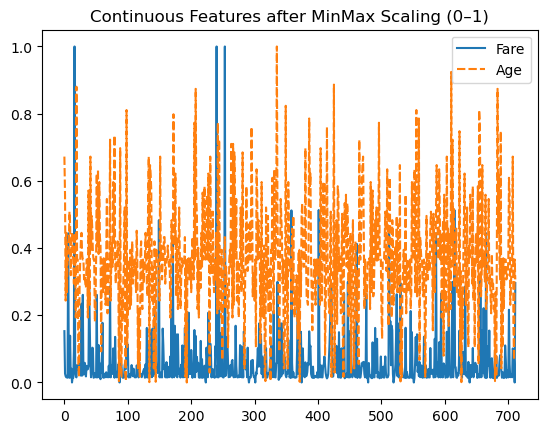

In [84]:
# ויזואליזציה לאחר סקאלינג
#ניתן לראות שכעת הערכים נעים בין 0 ל1
imputer = SimpleImputer(strategy="mean")
scaler  = MinMaxScaler()

tmp = trainset[['Fare','Age']].copy()
tmp[['Fare','Age']] = scaler.fit_transform(imputer.fit_transform(tmp[['Fare','Age']]))

sns.lineplot(data=tmp)
plt.title('Continuous Features after MinMax Scaling (0–1)')
plt.show()


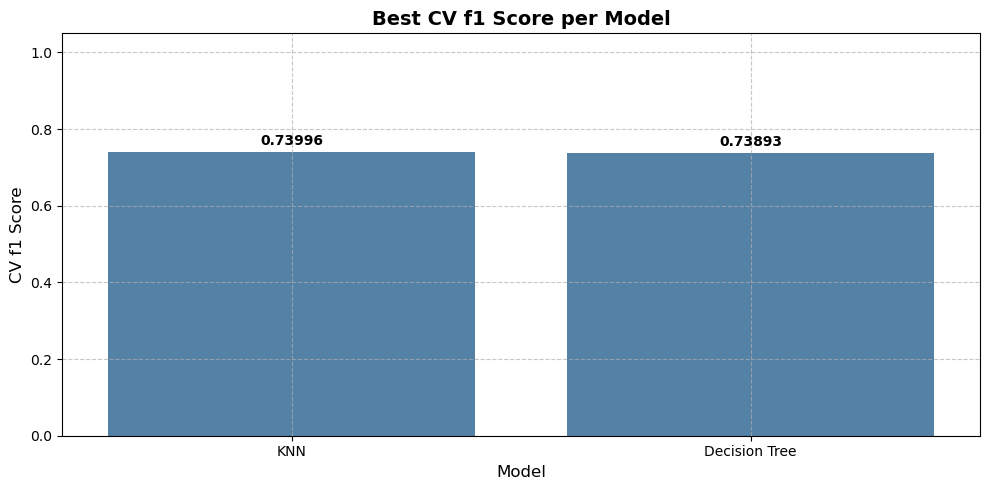

In [85]:
# 1. יצירת פיגורה חדשה עם גודל מתאים
plt.figure(figsize=(10, 5))

# 2. גרף עמודות להצגת התוצאות הטובות ביותר עבור CV F1 score

ax = sns.barplot(
    data=best_per_model,   # DataFrame עם עמודות "Model" ו-"CV f1"
    x="Model",             # עמודת המודלים על ציר ה-x
    y="CV f1",             # עמודת הציון על ציר ה-y
    color="steelblue"      # צבע אחיד לכל העמודות
)

# 3. הוספת הערות טקסט מעל כל עמודה להצגת הערך בדיוק
for i, row in best_per_model.iterrows():
    ax.text(
        x=i, 
        y=row["CV f1"] + 0.01,       
        s=f"{row['CV f1']:.5f}",   
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )

# 4. עיצוב כותרות וצירי הגרף
plt.title("Best CV f1 Score per Model", fontsize=14, fontweight='bold')
plt.xlabel("Model", fontsize=12)
plt.ylabel("CV f1 Score", fontsize=12)
plt.ylim(0, 1.05)         # קביעת טווח ציר ה-y בין 0 ל-1.05
plt.grid(True, linestyle='--', alpha=0.7)

# 5. סגירה והצגה של הפריסה
plt.tight_layout()
plt.show()

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [87]:
# 1. שליפת הקונפיגורציה (המודל הטוב ביותר) הטובה ביותר
best_config = results_df.iloc[0]
features = best_config["Features Config"]
model_name = best_config["Model"]
best_params = best_config["Best Parameters"]

# 2. הוספת פיצ'רים ל־ X_train מחדש (כולו)
X_final = add_features(X_train, **features)

numerical = ['Age', 'Fare']
categorical = ['Sex']

if features['use_family']:
    numerical.append('FamilySize')
if features['use_age']:
    numerical.append('AgeCategory')

# 3. יצירת preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]), numerical),
    
    ('cat', SimpleImputer(strategy='most_frequent'), categorical)
], remainder='passthrough')

# 4. יצירת המודל הרלוונטי
if model_name == "KNN":
    final_model = KNeighborsClassifier()
elif model_name == "Decision Tree":
    final_model = DecisionTreeClassifier()

# 5. יצירת pipeline עם הפרמטרים שנבחרו
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', final_model)
])


pipe.set_params(**best_params)

# 6. אימון על כל X_train
pipe.fit(X_final, y_train);




## Part 5 - Apply on test and show model performance estimation

In [89]:
# הוספת הפיצ'רים לטסט לפי הקונפיגורציה שנבחרה
X_test_final = add_features(X_test, **features)
y_pred = pipe.predict(X_test_final)

# חישוב מדדים
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

📈 ביצועי המודל על קבוצת הבדיקה:


,Metric,Value
0,Accuracy,0.837989
1,Precision,0.766667
2,Recall,0.754098
3,F1 Score,0.760331


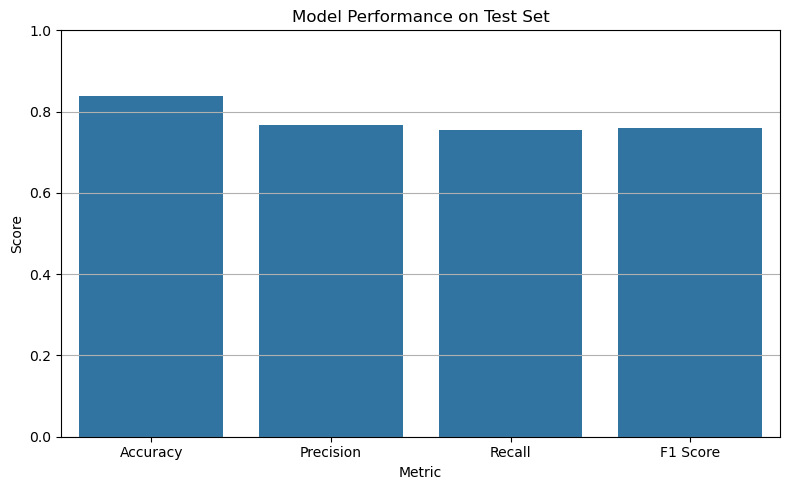

In [90]:
# הצגת טבלת ביצועים
performance_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})

print("📈 ביצועי המודל על קבוצת הבדיקה:")
display(performance_df)


# גרף ביצועים
plt.figure(figsize=(8, 5))
sns.barplot(x='Metric', y='Value', data=performance_df)
plt.ylim(0, 1)
plt.title('Model Performance on Test Set')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [91]:
# טבלת חיזויים לעומת אמת
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

print("🔍 השוואת חיזויים לעומת ערכים אמיתיים:")
display(predictions_df.head(20))

🔍 השוואת חיזויים לעומת ערכים אמיתיים:


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,1
4,1,0
5,1,1
6,0,1
7,0,0
8,1,1
9,0,0


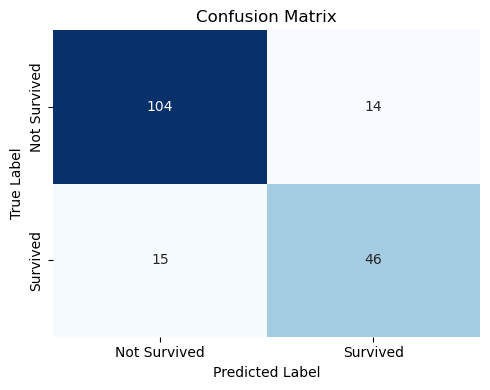

In [92]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()